# Project
Group Number: 6 
|Student Name|Email|Student Number|
|---|---|---|
|Cara Yuejia Li|yli564@uottawa.ca|300049083|
|Tong Zhao|tzhao018@uottawa.ca|300037013|
|Daniel Xu|zxu072@uottawa.ca|300030558|

In [1]:
import os
import cv2
import csv
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import classification_report, confusion_matrix

# for reproducibility purposes
SEED = 123
tf.random.set_seed(SEED)


Set target device to GPU

In [2]:
import tensorflow as tf
from tensorflow.python.keras import backend as K

# adjust values to your needs
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 12} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

#### Load Datasets

The shape of the training data is:  (28709, 2)
The shape of the validation data is:  (3589, 2)
The shape of the testing data is:  (3589, 2)
The head of the training data is: 
    emotion                                             pixels
0    angry  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1    angry  151 150 147 155 148 133 111 140 170 174 182 15...
2     fear  231 212 156 164 174 138 161 173 182 200 106 38...
3      sad  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4  neutral  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...
Index(['emotion', 'pixels'], dtype='object')


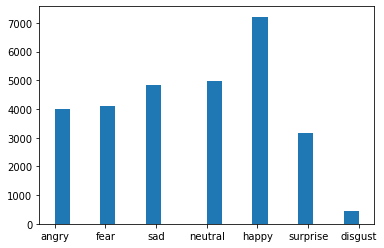

In [3]:
#read the raw data
raw_data = pd.read_csv("data/fer2013.csv", dtype={"emotion": str})
#raw_data = pd.read_csv("data/fer2013.csv")

#raw_data = raw_data.drop(raw_data[raw_data.emotion == "1"].index)

raw_data.loc[raw_data['emotion'] == '0', 'emotion'] = 'angry'
raw_data.loc[raw_data['emotion'] == '1', 'emotion'] = 'disgust'
raw_data.loc[raw_data['emotion'] == '2', 'emotion'] = 'fear'
raw_data.loc[raw_data['emotion'] == '3', 'emotion'] = 'happy'
raw_data.loc[raw_data['emotion'] == '4', 'emotion'] = 'sad'
raw_data.loc[raw_data['emotion'] == '5', 'emotion'] = 'surprise'
raw_data.loc[raw_data['emotion'] == '6', 'emotion'] = 'neutral'


#split data into training, validation and testing data
tmp_df = raw_data.groupby(raw_data['Usage'])
train_df = tmp_df.get_group("Training")
val_df = tmp_df.get_group("PublicTest")
test_df = tmp_df.get_group("PrivateTest")

# drop usage column
train_df = train_df.drop(columns=["Usage"])
val_df = val_df.drop(columns=["Usage"])
test_df = test_df.drop(columns=["Usage"])

#print the shape of the data
print("The shape of the training data is: ", train_df.shape)
print("The shape of the validation data is: ", val_df.shape)
print("The shape of the testing data is: ", test_df.shape)

#print the head of the data
print("The head of the training data is: \n", train_df.head())

#print column names
print(train_df.columns)

#plot the histogram of the emotion data
plt.hist(train_df.emotion, bins=20)
plt.show()

In [4]:
train_df.head()

,emotion,pixels
0,angry,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,angry,151 150 147 155 148 133 111 140 170 174 182 15...
2,fear,231 212 156 164 174 138 161 173 182 200 106 38...
3,sad,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,neutral,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


#### Data Oversampling and Undersampling

(28709, 2)
(35000, 2)
New class distribution is
[('angry', 5000), ('disgust', 5000), ('fear', 5000), ('happy', 5000), ('neutral', 5000), ('sad', 5000), ('surprise', 5000)]
  emotion                                             pixels
0   angry  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1   angry  151 150 147 155 148 133 111 140 170 174 182 15...
2   angry  30 24 21 23 25 25 49 67 84 103 120 125 130 139...
3   angry  123 125 124 142 209 226 234 236 231 232 235 22...
4   angry  8 9 14 21 26 32 37 46 52 62 72 70 71 73 76 83 ...


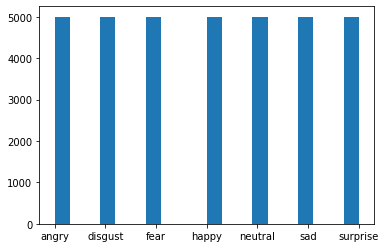

In [5]:
X_train, y_train = train_df["pixels"].values.reshape(-1,1), train_df["emotion"]

#undersample the data
undersampler = RandomUnderSampler(sampling_strategy={'happy': 5000})
X_over, y_over = undersampler.fit_resample(X_train, y_train)

# #oversample the data
oversampler = RandomOverSampler(sampling_strategy={'disgust':5000, 'angry': 5000, 'fear': 5000, 'sad': 5000, 'surprise': 5000, 'neutral': 5000})
X_over, y_over = oversampler.fit_resample(X_over, y_over)

print(train_df.shape)

#Create a dataframe with the oversampled data
new_train_df = pd.DataFrame(data=y_over, columns=["emotion"])
new_train_df["pixels"] = X_over
#new_train_df = new_train_df.sample(frac=1).reset_index(drop=True)
print(new_train_df.shape)
print(f"New class distribution is\n{sorted(Counter(new_train_df['emotion']).items())}")
print(new_train_df.head())

#plot the histogram of the emotion data after solving the data imbalance problem
plt.hist(new_train_df.emotion, bins=20)
plt.show()


In [6]:
# create a new column called "image_name"
def insert_img_name(df):
    i = 1
    img_name_ls = []
    while i < df.shape[0] + 1:
        img_name = "Data_" + str(i) + ".jpg"
        img_name_ls.append(img_name)
        i += 1
    df.insert(2, "image_name", img_name_ls)

insert_img_name(new_train_df)
insert_img_name(val_df)
insert_img_name(test_df)

#save the dataframe as csv file
new_train_df.to_csv("data/new_train.csv", index=False)
val_df.to_csv("data/val.csv", index=False)
test_df.to_csv("data/test.csv", index=False)

#### Convert Pixels To Images

In [7]:
#split the pixels and save as array
def p_to_arr(pixels):
    arr = np.array(pixels.split(),'uint8')
    return arr

#reshape the image
def reshape_img(data):
    image = np.reshape(data['pixels'].to_list(),(data.shape[0],48,48,1))
    image = np.repeat(image, 3, -1)
    return image

# new_train_df.loc[new_train_df['pixels'] == '*', 'pixels'] = new_train_df['pixels'].apply(p_to_arr)
# val_df.loc[val_df['pixels'] == '*', 'pixels'] = val_df['pixels'].apply(p_to_arr)
# test_df.loc[test_df['pixels'] == '*', 'pixels'] = test_df['pixels'].apply(p_to_arr)

#apply the function to the dataframe
new_train_df['pixels'] = new_train_df['pixels'].apply(p_to_arr)
val_df['pixels'] = val_df['pixels'].apply(p_to_arr)
test_df['pixels']  = test_df['pixels'].apply(p_to_arr)


#reshape the image
re_train = reshape_img(new_train_df)
print(re_train.shape)

re_val = reshape_img(val_df)
print(re_val.shape)

re_test = reshape_img(test_df)
print(re_test.shape)

#save the reshaped images and name them as "Data_1.jpg", "Data_2.jpg", etc.
def save_as_dir(dir, data):
    num = np.arange(1,1000000)
    for i in range(len(data)):
        namefile = "Data_"+ str(num[i]) +".jpg"
        cv2.imwrite(os.path.join(dir,namefile), data[i])

#make a directory to save the images
dataset_dir = "./dataset"
train_dir = "./dataset/train"
val_dir = "./dataset/validation"
test_dir = "./dataset/test"

os.makedirs(dataset_dir,exist_ok=True)
os.makedirs(train_dir,exist_ok=True)
os.makedirs(val_dir,exist_ok=True)
os.makedirs(test_dir,exist_ok=True)

#save the images
save_as_dir(train_dir, re_train)
save_as_dir(val_dir, re_val)
save_as_dir(test_dir, re_test)

(35000, 48, 48, 3)
(3589, 48, 48, 3)
(3589, 48, 48, 3)


#### Create Image Generator

In [8]:
batch_size = 128

#create the training generator
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_generator.flow_from_dataframe(
    dataframe = new_train_df,
    directory = 'dataset/train/',
    x_col = 'image_name',
    y_col = 'emotion',
    batch_size = batch_size,
    target_size = (48,48),
    seed = 42,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

#create the validation generator
val_generator = ImageDataGenerator(rescale=1./255)

val_generator = val_generator.flow_from_dataframe(
    dataframe = val_df,
    directory = 'dataset/validation/',
    x_col = 'image_name',
    y_col = 'emotion',
    batch_size = batch_size,
    target_size = (48,48),
    seed = 42,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)


#create the test generator
test_generator = ImageDataGenerator(rescale=1./255)

test_generator = test_generator.flow_from_dataframe(
    dataframe = test_df,
    directory = 'dataset/test/',
    x_col = 'image_name',
    y_col = 'emotion',
    batch_size = batch_size,
    target_size = (48,48),
    seed = 42,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = False
)


Found 35000 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.
Found 3589 validated image filenames belonging to 7 classes.


#### Show Sample Image

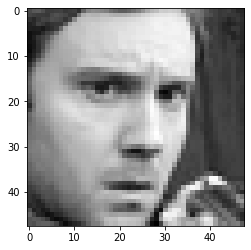

(None, 'angry')

In [9]:
#print the first image in the training data
def show_image(image):
    img = image.reshape(48,48,1)
    plt.imshow(img, cmap= "gray", interpolation="nearest")
    plt.show()

# split the pixels and rescale the first image
fir_pixel, label = new_train_df["pixels"][0], new_train_df["emotion"][0]
fir_img = np.array(fir_pixel, 'float32')
fir_img /= 255

#show the first image
show_image(fir_img), label

#### Create the Model

In [10]:
# specify the model input with the required shape 
input_shape = keras.Input(shape=(48,48,3))

#create the model
#convolutional layer and max pooling layer
x = layers.Conv2D(32, (3,3), padding = 'same' , activation = 'relu')(input_shape)
x = layers.Conv2D(32, (3,3), padding = 'same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(64, (3,3), padding = 'same', activation = 'relu')(x)
x = layers.Conv2D(64, (3,3), padding = 'same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(128, (3,3), padding = 'same', activation='relu')(x)
x = layers.Conv2D(128, (3,3), padding = 'same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

x = layers.Conv2D(256, (3,3), padding = 'same', activation='relu')(x)
x = layers.Conv2D(256, (3,3), padding = 'same', activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2,2), padding='same')(x)

#fully connected layer
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)

# x = layers.Dense(2048, activation='relu')(x)
# x = layers.Dropout(0.2)(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(512, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation = 'relu')(x)

y = layers.Dense(7, activation='softmax', name = 'emotion')(x)

#create the model with the required input and the outputs
model = keras.Model(inputs=input_shape, outputs=y)

#print the model summary
print(model.summary())

#Instantiate the optimizer with the learning rate.
optimizer = keras.optimizers.RMSprop(learning_rate=1e-3)

#compile the model
model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])

#Define the callback functions
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Model checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'models',
    monitor = 'val_loss',
    save_best_only = True
)

#ReduceLROnPlateau callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 1e-5,
    verbose = 1
)

#fit the model
model.fit(
    train_generator,
    epochs = 30,
    validation_data = val_generator,
    callbacks = [early_stopping, checkpoint, reduce_lr],
    steps_per_epoch = len(new_train_df)/batch_size,
    validation_steps = len(val_df)/batch_size
)


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 48, 48, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 48, 48, 32)        896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 32)        9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        36928 

In [11]:
#evaluate the model
test_generator.reset()
test_evals = model.evaluate(test_generator)
print(test_evals)
print(f"loss: {test_evals[0]}, accuracy: {test_evals[1]}")


29/29 [==============================] - 1s 26ms/step - loss: 0.9985 - accuracy: 0.6141
[0.9985158443450928, 0.6140986084938049]
loss: 0.9985158443450928, accuracy: 0.6140986084938049


In [12]:
#prediction
emotions = {0: 'angry', 1:'disgust'  ,2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
test_generator.reset()
predictions = model.predict(test_generator)
#print(predictions)
predictions = np.argmax(predictions, axis=1)
#predictions = [emotions[i] for i in predictions]

cr = classification_report(test_generator.classes, predictions, target_names=list(emotions.values()))
print(cr)


              precision    recall  f1-score   support

       angry       0.49      0.61      0.54       491
     disgust       0.49      0.71      0.58        55
        fear       0.49      0.23      0.32       528
       happy       0.91      0.79      0.84       879
         sad       0.54      0.75      0.63       626
    surprise       0.48      0.40      0.44       594
     neutral       0.65      0.82      0.73       416

    accuracy                           0.61      3589
   macro avg       0.58      0.62      0.58      3589
weighted avg       0.62      0.61      0.60      3589



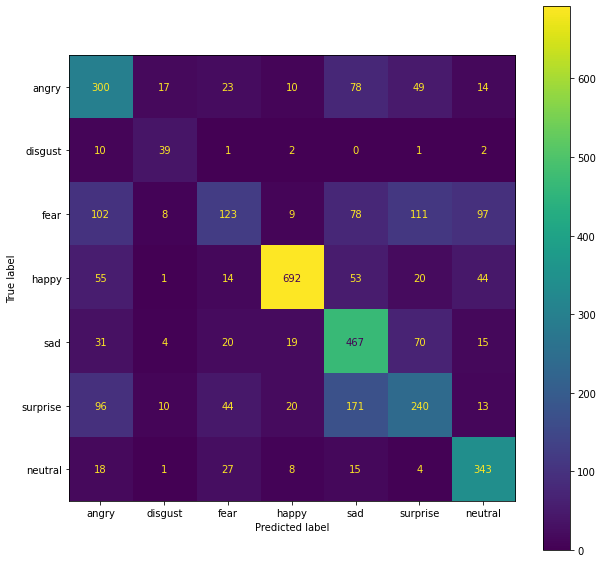

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


cm = confusion_matrix(test_generator.classes, predictions, labels=list(emotions.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(emotions.values()))

#set figure size
fig, ax = plt.subplots(figsize=(10,10))

disp = disp.plot(include_values=True, cmap='viridis', ax=ax)


In [13]:
#save the model to disk
model.save('model.h5')

#load the model from disk
model = keras.models.load_model('model.h5')

### Pretrained Models

In [16]:
nas_net = tf.keras.applications.MobileNetV2()
base_input = nas_net.layers[0].input
base_output = nas_net.layers[-2].output
final_output = layers.Dense(128)(base_output) 
final_output = layers.Activation('relu')(final_output) 
final_output = layers.Dense(64)(final_output)
final_output = layers.Activation('relu')(final_output)
final_output = layers.Dense(7, activation='softmax')(final_output) 
model_nas_net = keras.Model(inputs = base_input, outputs = final_output)
model_nas_net.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#Define the callback functions
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Model checkpoint callback
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath = 'models',
    monitor = 'val_loss',
    save_best_only = True
)

#ReduceLROnPlateau callback
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.1,
    patience = 2,
    min_lr = 1e-5,
    verbose = 1
)

#fit the model
model_nas_net.fit(
    train_generator,
    epochs = 10,
    validation_data = val_generator,
    callbacks = [early_stopping, checkpoint, reduce_lr],
    steps_per_epoch = len(new_train_df)/batch_size,
    validation_steps = len(val_df)/batch_size
)

Epoch 1/10
273/273 [==============================] - 28s 87ms/step - loss: 1.7844 - accuracy: 0.2904 - val_loss: 2.3545 - val_accuracy: 0.1811
INFO:tensorflow:Assets written to: models\assets
Epoch 2/10
273/273 [==============================] - 23s 85ms/step - loss: 1.5241 - accuracy: 0.4197 - val_loss: 2.7461 - val_accuracy: 0.2432
Epoch 3/10
273/273 [==============================] - 23s 86ms/step - loss: 1.4184 - accuracy: 0.4652 - val_loss: 2.4022 - val_accuracy: 0.3647

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 4/10
273/273 [==============================] - 23s 85ms/step - loss: 1.2998 - accuracy: 0.5059 - val_loss: 2.1306 - val_accuracy: 0.3795
INFO:tensorflow:Assets written to: models\assets
Epoch 5/10
273/273 [==============================] - 23s 85ms/step - loss: 1.2472 - accuracy: 0.5245 - val_loss: 1.7187 - val_accuracy: 0.4257
INFO:tensorflow:Assets written to: models\assets
Epoch 6/10
273/273 [==============================]